Neo4j URI: neo4j://127.0.0.1:7687
Neo4j User: neo4j
Cohere API Key: Set
Successfully loaded file: data/runpls.txt
Content preview: Steve jobs founded Apple in 1985 in liberty headquarters. 
Nvidia was founded by Jensen Huang in Eswar headquarters. 
Elon Musk founded Tesla.
Tesla manufactures electric cars.
SpaceX was founded by E...


c:\Users\Eswaran\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully connected to Neo4j
Creating Knowledge Graph Index...


Processing nodes: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: entity)} {position: line: 1, column: 43, offset: 42} for query: 'MATCH (n) RETURN coalesce(n.name, n.id, n.entity) as entity LIMIT 10'


Knowledge Graph Index created successfully and stored in Neo4j
Nodes in Neo4j: 13
Relationships in Neo4j: 10
Sample entities: ['Steve jobs', '1985', 'Apple', 'Liberty headquarters', 'Nvidia', 'Jensen huang', 'Eswar headquarters', 'Elon musk', 'Tesla', 'Electric cars']
No persisted index found in storage context, rebuilding from documents: No index in storage context, check if you specified the right persist_dir.


Processing nodes: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Graph nodes: []
Graph edges: []


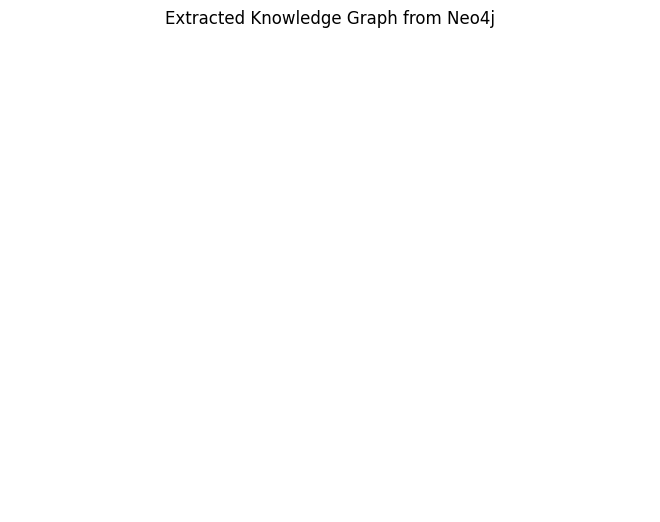

Creating query engine...
Query response: None


In [ ]:
from llama_index.core import Document, KnowledgeGraphIndex, Settings, StorageContext
from llama_index.llms.cohere import Cohere
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.graph_stores.neo4j import Neo4jGraphStore
from dotenv import load_dotenv
import os

# Set API Key
load_dotenv(dotenv_path="project.env")
cohere_api_key = os.getenv("COHERE_API_KEY")
neo4j_uri = os.getenv("NEO4J_URI")
neo4j_user = os.getenv("NEO4J_USERNAME")
neo4j_password = os.getenv("NEO4J_PASSWORD")

print(f"Neo4j URI: {neo4j_uri}")
print(f"Neo4j User: {neo4j_user}")
print(f"Cohere API Key: {'Set' if cohere_api_key else 'Not Set'}")

# Read file
file_path = "data/sampledata.txt"
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        text_content = file.read()
    documents = [Document(text=text_content)]
    print(f"Successfully loaded file: {file_path}")
    print(f"Content preview: {text_content[:200]}...")
except FileNotFoundError:
    print(f"File not found: {file_path}")
    exit(1)

# Set up Cohere LLM and embedding
Settings.llm = Cohere(model="command-r", api_key=cohere_api_key)
Settings.embed_model = CohereEmbedding(
    model_name="embed-english-v3.0",
    api_key=cohere_api_key
)

# Connect to Neo4j
try:
    graph_store = Neo4jGraphStore(
        username=neo4j_user,
        password=neo4j_password,
        url=neo4j_uri,
        database="neo4j",
    )
    print("Successfully connected to Neo4j")
except Exception as e:
    print(f"Error connecting to Neo4j: {e}")
    exit(1)

# Create Storage Context
storage_context = StorageContext.from_defaults(graph_store=graph_store)

# Create Knowledge Graph Index and store in Neo4j
print("Creating Knowledge Graph Index...")
try:
    kg_index = KnowledgeGraphIndex.from_documents(
        documents,
        storage_context=storage_context,
        max_triplets_per_chunk=10,
        include_embeddings=True,
        show_progress=True,
        extract_keywords=True,
    )
    print("Knowledge Graph Index created successfully and stored in Neo4j")
except Exception as e:
    print(f"Error creating Knowledge Graph Index: {e}")
    exit(1)

# Verify data in Neo4j
try:
    from neo4j import GraphDatabase
    driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_user, neo4j_password))
    with driver.session() as session:
        node_count = session.run("MATCH (n) RETURN count(n) as node_count").single()["node_count"]
        rel_count = session.run("MATCH ()-[r]->() RETURN count(r) as rel_count").single()["rel_count"]
        print(f"Nodes in Neo4j: {node_count}")
        print(f"Relationships in Neo4j: {rel_count}")

        result = session.run(
            "MATCH (n) RETURN coalesce(n.name, n.id, n.entity) as entity LIMIT 10"
        )
        entities = [record["entity"] for record in result]
        print(f"Sample entities: {entities}")
    driver.close()
except Exception as e:
    print(f"Error checking Neo4j data: {e}")

# replace your KnowledgeGraphIndex.from_storage(...) block with this
from llama_index.core import load_index_from_storage, StorageContext

# rebuild the storage_context (you already have graph_store)
storage_context = StorageContext.from_defaults(graph_store=graph_store)

try:
    # load the persisted index from storage (will return a KnowledgeGraphIndex if that's what was stored)
    kg_index = load_index_from_storage(
        storage_context,               # required
        index_id=None,                 # leave None if only one index present
        max_triplets_per_chunk=10,     # optional kwargs passed to the index constructor
        include_embeddings=True
    )
    print("Loaded KnowledgeGraphIndex from storage.")
except ValueError as e:
    # common error: "No index in storage context..." — nothing persisted in index_store
    print("No persisted index found in storage context, rebuilding from documents:", e)
    kg_index = KnowledgeGraphIndex.from_documents(
        documents,
        storage_context=storage_context,
        max_triplets_per_chunk=10,
        include_embeddings=True,
        show_progress=True,
        extract_keywords=True,
    )
# ✅ STEP 9: Visualize NetworkX Graph
import matplotlib.pyplot as plt
import networkx as nx

G = kg_index.get_networkx_graph(limit=100)
print("Graph nodes:", G.nodes())
print("Graph edges:", G.edges())

nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Extracted Knowledge Graph from Neo4j")
plt.show()

# ✅ STEP 10: Query the KG
print("Creating query engine...")
query_engine = kg_index.as_query_engine(include_text=True, response_mode="no_text")
response = query_engine.query("Who founded Apple?")
print("Query response:", response)

Neo4j URI: neo4j://127.0.0.1:7687
Neo4j User: neo4j
Cohere API Key: Set
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage\docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage\index_store.json.
📂 Loading index from local storage...
Nodes in Neo4j: 13
Relationships in Neo4j: 10
Graph nodes: []
Graph edges: []


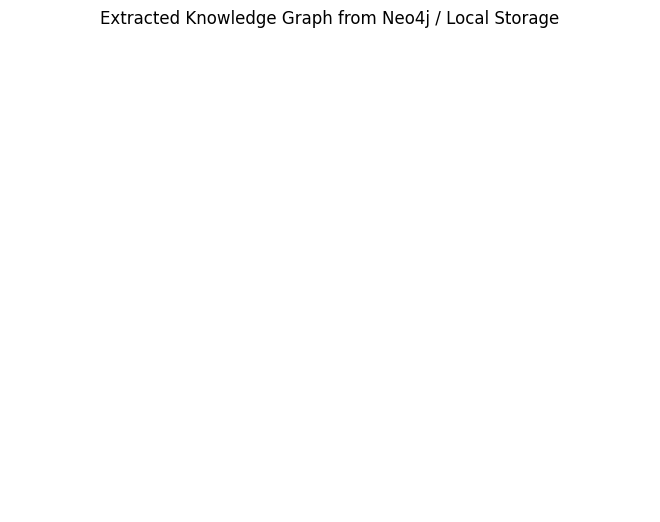

Query response: None


In [ ]:
from llama_index.core import Document, KnowledgeGraphIndex, Settings, StorageContext, load_index_from_storage
from llama_index.llms.cohere import Cohere
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.graph_stores.neo4j import Neo4jGraphStore
from llama_index.core import load_index_from_storage
from llama_index.core.indices.knowledge_graph import KnowledgeGraphIndex
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import networkx as nx

#  Load environment variables 
load_dotenv(dotenv_path="project.env")
cohere_api_key = os.getenv("COHERE_API_KEY")
neo4j_uri = os.getenv("NEO4J_URI")
neo4j_user = os.getenv("NEO4J_USERNAME")
neo4j_password = os.getenv("NEO4J_PASSWORD")

print(f"Neo4j URI: {neo4j_uri}")
print(f"Neo4j User: {neo4j_user}")
print(f"Cohere API Key: {'Set' if cohere_api_key else 'Not Set'}")

# Setup Cohere 
Settings.llm = Cohere(model="command-r", api_key=cohere_api_key)
Settings.embed_model = CohereEmbedding(model_name="embed-english-v3.0", api_key=cohere_api_key)

#  Neo4j connection 
graph_store = Neo4jGraphStore(
    username=neo4j_user,
    password=neo4j_password,
    url=neo4j_uri,
    database="neo4j",
)
storage_context = StorageContext.from_defaults(graph_store=graph_store)

#  Create or load index 
PERSIST_DIR = "./storage"

PERSIST_DIR = "./storage"
storage_context = StorageContext.from_defaults(
    graph_store=graph_store,
    persist_dir=PERSIST_DIR
)

if os.path.exists(PERSIST_DIR) and os.listdir(PERSIST_DIR):
    print("📂 Loading index from local storage...")
    kg_index = load_index_from_storage(
        storage_context,
        index_cls=KnowledgeGraphIndex
    )
else:
    print("🆕 Creating new Knowledge Graph Index...")
    file_path = "data/runpls.txt"
    with open(file_path, 'r', encoding='utf-8') as file:
        text_content = file.read()

    documents = [Document(text=text_content)]
    kg_index = KnowledgeGraphIndex.from_documents(
        documents,
        storage_context=storage_context,
        max_triplets_per_chunk=10,
        include_embeddings=True,
        show_progress=True,
        extract_keywords=True,
    )

    # Persist to disk
    storage_context.persist()
    print("💾 Index persisted to disk.")


# Verify Neo4j data 
from neo4j import GraphDatabase
driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_user, neo4j_password))
with driver.session() as session:
    node_count = session.run("MATCH (n) RETURN count(n) as node_count").single()["node_count"]
    rel_count = session.run("MATCH ()-[r]->() RETURN count(r) as rel_count").single()["rel_count"]
    print(f"Nodes in Neo4j: {node_count}")
    print(f"Relationships in Neo4j: {rel_count}")
driver.close()

# Visualize with NetworkX 
G = kg_index.get_networkx_graph(limit=100)
print("Graph nodes:", list(G.nodes()))
print("Graph edges:", list(G.edges()))

nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Extracted Knowledge Graph from Neo4j / Local Storage")
plt.show()

#STEP 7: Query
query_engine = kg_index.as_query_engine(include_text=True, response_mode="no_text")
response = query_engine.query("Who founded Apple?")
print("Query response:", response)


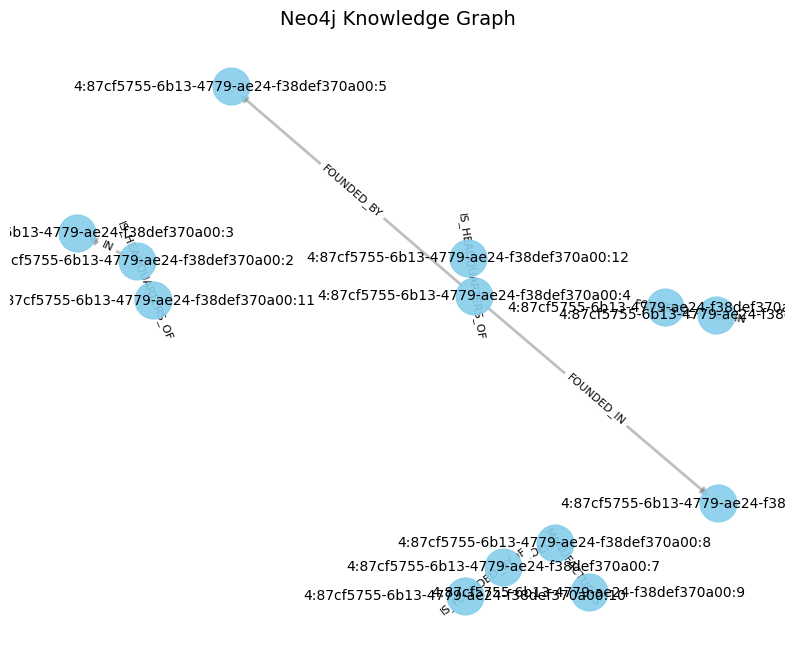

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is already built
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, seed=42)  # consistent layout

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Optional: show relationship types on edges
edge_labels = nx.get_edge_attributes(G, 'type')  # from your Cypher return
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.axis('off')
plt.title("Neo4j Knowledge Graph", fontsize=14)
plt.show()

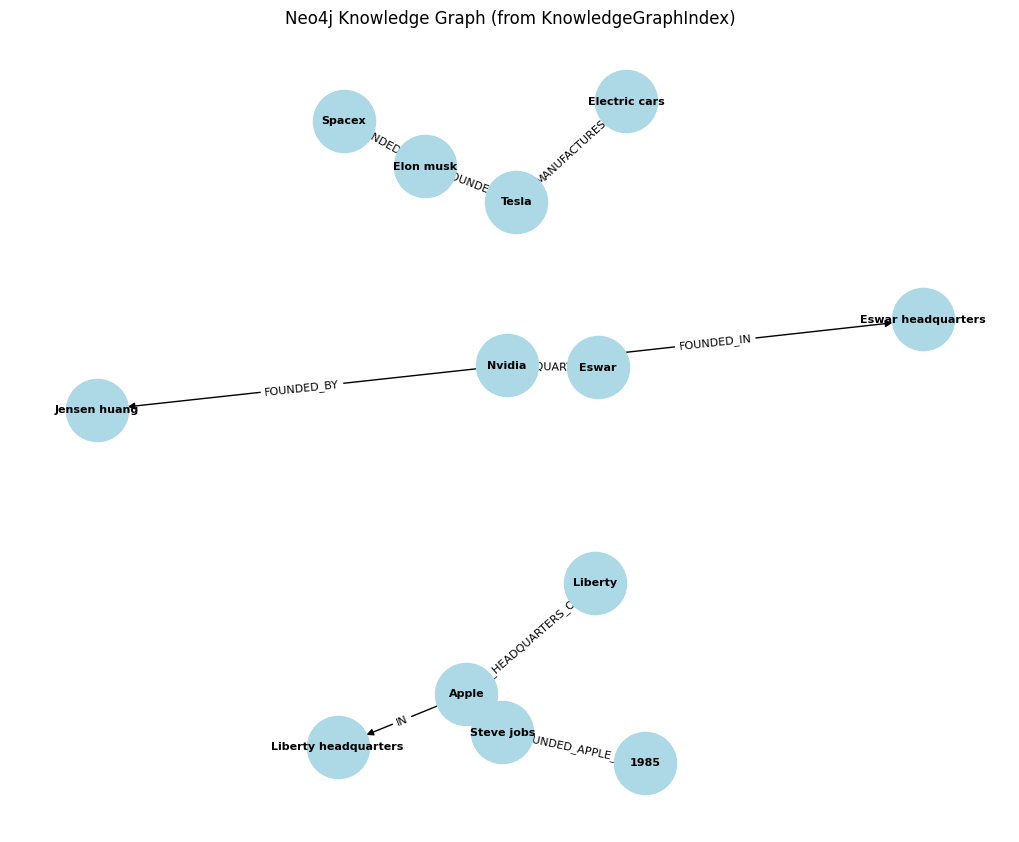

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

#always use.env i am lazy
NEO4J_URI = ""
NEO4J_USER = ""
NEO4J_PASSWORD = ""

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Create NetworkX graph
G = nx.DiGraph()

# Fetch nodes
with driver.session() as session:
    result = session.run("""
        MATCH (n)
        RETURN elementId(n) as id, labels(n) as labels, properties(n) as props
    """)
    for record in result:
        props = record["props"]
        name = props.get("name") or props.get("id") or props.get("value") or "<no name>"
        G.add_node(record["id"], label=name, labels=record["labels"])

# Fetch relationships
with driver.session() as session:
    result = session.run("""
        MATCH (a)-[r]->(b)
        RETURN elementId(a) as source, type(r) as type, elementId(b) as target
    """)
    for record in result:
        G.add_edge(record["source"], record["target"], label=record["type"])

driver.close()

#  Draw graph
pos = nx.spring_layout(G, k=0.5, iterations=50)
node_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, node_color="lightblue", font_size=8, font_weight="bold", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Neo4j Knowledge Graph (from KnowledgeGraphIndex)")
plt.show()

Neo4j URI: neo4j://127.0.0.1:7687
Neo4j User: neo4j
Cohere API Key: Set
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage\docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage\index_store.json.
📂 Loading index from local storage...
Nodes in Neo4j: 13
Relationships in Neo4j: 10

--- Graph Triplets ---

Graph nodes: []
Graph edges: []


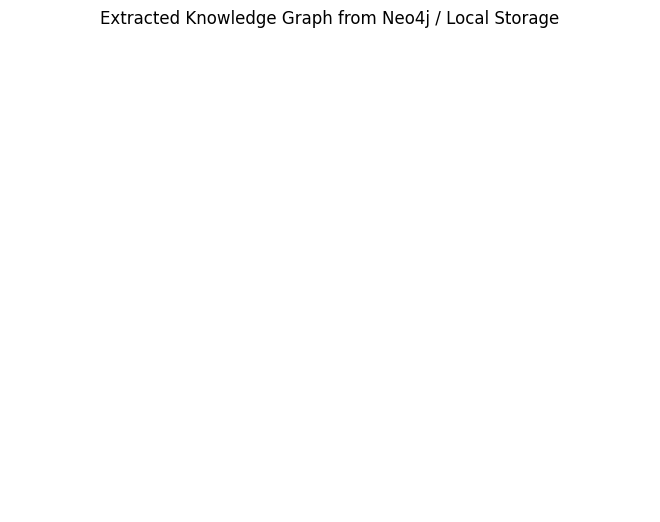


Q: Where was apple found?
A: Apple was founded in Liberty headquarters.


In [ ]:
from llama_index.core import Document, KnowledgeGraphIndex, Settings, StorageContext, load_index_from_storage
from llama_index.llms.cohere import Cohere
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.graph_stores.neo4j import Neo4jGraphStore
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase

# STEP 1: Load environment variables 
load_dotenv(dotenv_path="project.env")
cohere_api_key = os.getenv("COHERE_API_KEY")
neo4j_uri = os.getenv("NEO4J_URI")
neo4j_user = os.getenv("NEO4J_USERNAME")
neo4j_password = os.getenv("NEO4J_PASSWORD")

print(f"Neo4j URI: {neo4j_uri}")
print(f"Neo4j User: {neo4j_user}")
print(f"Cohere API Key: {'Set' if cohere_api_key else 'Not Set'}")

# STEP 2: Setup Cohere 
Settings.llm = Cohere(model="command-r", api_key=cohere_api_key)
Settings.embed_model = CohereEmbedding(model_name="embed-english-v3.0", api_key=cohere_api_key)

#  STEP 3: Neo4j connection 
graph_store = Neo4jGraphStore(
    username=neo4j_user,
    password=neo4j_password,
    url=neo4j_uri,
    database="neo4j",
)
storage_context = StorageContext.from_defaults(graph_store=graph_store)

#  STEP 4: Create or load index 
PERSIST_DIR = "./storage"
storage_context = StorageContext.from_defaults(
    graph_store=graph_store,
    persist_dir=PERSIST_DIR
)

if os.path.exists(PERSIST_DIR) and os.listdir(PERSIST_DIR):
    print("📂 Loading index from local storage...")
    kg_index = load_index_from_storage(
        storage_context,
        index_cls=KnowledgeGraphIndex
    )
else:
    print("🆕 Creating new Knowledge Graph Index...")
    file_path = "data/runpls.txt"
    with open(file_path, 'r', encoding='utf-8') as file:
        text_content = file.read()

    documents = [Document(text=text_content)]
    kg_index = KnowledgeGraphIndex.from_documents(
        documents,
        storage_context=storage_context,
        max_triplets_per_chunk=10,
        include_embeddings=True,
        show_progress=True,
        extract_keywords=True,
    )

    storage_context.persist()
    print("💾 Index persisted to disk.")

# STEP 5: Verify Neo4j data 
driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_user, neo4j_password))
with driver.session() as session:
    node_count = session.run("MATCH (n) RETURN count(n) as node_count").single()["node_count"]
    rel_count = session.run("MATCH ()-[r]->() RETURN count(r) as rel_count").single()["rel_count"]
    print(f"Nodes in Neo4j: {node_count}")
    print(f"Relationships in Neo4j: {rel_count}")
driver.close()

# STEP 6: Visualize + Debug KG Triplets 
G = kg_index.get_networkx_graph(limit=100)
print("\n--- Graph Triplets ---")
for src, dst, data in G.edges(data=True):
    print(f"{src} -[{data.get('relation')}]-> {dst}")

print("\nGraph nodes:", list(G.nodes()))
print("Graph edges:", list(G.edges()))

nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Extracted Knowledge Graph from Neo4j / Local Storage")
plt.show()

# Query with LLM reasoning ====
query_engine = kg_index.as_query_engine
    include_text=True,               # get original text for reasoning
    response_mode="tree_summarize",  # let LLM synthesize answer
    similarity_top_k=5               # retrieve more context
)

question = "Where was apple found?"
response = query_engine.query(question)
print(f"\nQ: {question}")
print(f"A: {response}")

